# 나랑 닮은 연예인을 찾아보자
---
학습한 내용을 바탕으로 연예인 사진과 나를 비교해 보자 ٩(ˊᗜˋ*)و

## Step 0. 설계
---
내 사진과 다른 사람의 사진을 비교하기 위해서 다음과 같은 순서로 프로젝트를 진행할 것이다.
1. 자료수집 : 비교를 위한 사진을 모은다.
    - 내 사진 찍기
        - 본인의 사진을 2장 이상 포함시킨다.
        - 사진들 사이의 얼굴 임베딩 벡터 거리를 구하고 사진들이 닮았는지 확인한다. 닮을 수록 좋은 베이스라인이 될 수 있다.
    - 연예인 사진 모으기
        - 모든 사진이 많을수록 닮은 연예인을 찾을 가능성이 높아질 것이다!
2. 얼굴 영역 자르기
    - 수집한 자료들에서 얼굴 영역만 잘라낸다.
    - 자른 이미지는 `PIL`의 `Image.fromarray`를 통해서 PIL Image로 변환한 뒤에 저장을 해두면 다양한를 시도해 볼 수 있다.
    ```python
    # 힌트
    from PIL import Image
    face = get_gropped_face(image_path)
    pillow_image = Image.fromarray(face)
    pillow_image.save(path_to_save)
    ```
3. 얼굴 영역의 임베딩 추출
    - `face_recognition`을 활용하여 이미지로부터 임베딩을 추출한다.
    - `get_face_embedding(face)` : 얼굴영역으로부터 얼굴 임베딩 벡터를 구하는 함수
    - `get_face_embedding_dict(dir_path)` : 디렉토리 안에 있는 모든 이미지의 임베딩 딕셔너리를 구하는 함수
4. 이미지 비교
    - 모은 연예인 사진들과 자신의 얼굴 사진에서 추출한 임베딩 벡터들 간의 거리를 비교해 보고 가장 작은 연예인이 누구인지 찾아본다.
    - `get_nearest_face(name, top=5)`
    - 이때, 자신과 가장 닮았다는 것은 입력된 자신의 이미지들과 가장 유사한 n개의 사진을 추출하고 그 중에서 가장 빈도수가 높은 상위 사진들을 뽑아내는 것으로 정의한다.
5. 다양한 시각화 시도
    - 비단 닮은 꼴 연예인을 찾기만 할 것이 아니라, 그들의 얼굴 사진을 활용하여 재미있는 시각화를 시도해보자.
    - tkinter나 flask를 활용해서 닮은꼴을 찾을 이미지를 업로드한 후 그 이미지와 닮은 얼굴을 찾는 형태로 구현해 보는 것도 재미있을 것이다.

## Step1. Code refactoring / Code Collection
---

- 이번 프로젝트에서는 코드를 모두 한 클래스에 모아 단순한 함수 호출을 통하여 실습을 진행할 수 있도록 구조를 디자인하였다.

### import packages

In [11]:
import face_recognition
import os
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import pickle
import pandas as pd


%config Completer.use_jedi = False
%load_ext autotime

workspace_path =  os.getenv('HOME') + '/workspace/aiffel-exploration-workspace/E07_face_embedding'

time: 357 µs (started: 2021-02-04 20:44:30 +09:00)


### SimilarFaceFinder

#### 정의

In [111]:
class SimilarFaceFinder:
    def __init__(self):
        self.embedding_dict = {}
        self.file_path_dict = {}
    
    def get_cropped_face(self, image_file):
        image = face_recognition.load_image_file(image_file)
        face_locations = face_recognition.face_locations(image)
            
        if len(face_locations) == 0:
            cropped_face = []  # 얼굴 인식 실패
        else :
            a, b, c, d = face_locations[0]
            cropped_face = image[a:c,d:b,:]
        return cropped_face
 
    def get_face_embedding_dict(self, dir_path):
        print(f'>>> face embedding start...')
        
        file_list = os.listdir(dir_path)
        embedding_dict = {}

        for file in file_list:
            face = self.get_cropped_face(os.path.join(dir_path, file))
            if len(face) == 0: continue # 얼굴 인식 실패
            
            embedding = face_recognition.face_encodings(face)
            if len(embedding) > 0:
                # 얼굴영역 face가 제대로 detect되지 않으면  len(embedding)==0인 경우가 발생하므로 
                # os.path.splitext(file)[0]에는 이미지파일명에서 확장자를 제거한 이름이 담깁니다.
                embedding_dict[os.path.splitext(file)[0]] = embedding[0]
        print(f'>>> face embedding end ✧⁺⸜(･ ᗜ ･ )⸝⁺✧\n')
        return embedding_dict
    
    def set_embedding_dict(self, celebrity_img_path):
        self.embedding_dict = self.get_face_embedding_dict(celebrity_img_path)
    
    def load_embedding_dict(self, dict_path):
        with open(dict_path, 'rb') as fr: 
            self.embedding_dict = pickle.load(fr)
    
    def save_embedding_dict(self, dict_path):
        with open(dict_path,'wb') as fw:
            pickle.dump(self.embedding_dict, fw)
    
    def get_file_path_dict(self, dir_path):
        file_list = os.listdir(dir_path)
        file_path_dict = { os.path.splitext(file)[0] : file for file in file_list }
        return file_path_dict
    
    def set_file_path_dict(self, dir_path):
        self.file_path_dict = self.get_file_path_dict(dir_path)
    
    def load_file_path_dict(self, dict_path):
        with open(dict_path, 'rb') as fr: 
            self.file_path_dict = pickle.load(fr)
    
    def save_file_path_dict(self, dict_path):
        with open(dict_path,'wb') as fw:
            pickle.dump(self.file_path_dict, fw)

    def get_celebrity_list(self): 
        return self.embedding_dict.keys()
    
    def get_distance(self, vec1, vec2):
        return np.linalg.norm(vec1-vec2, ord=2)
    
    def get_nearest_face(self, target, n, verbose=0):
        res = self.embedding_dict.copy()
        res = sorted(res.items(), key=lambda x: self.get_distance(target, x[1]))
        res = [ (e[0], self.get_distance(target, self.embedding_dict[e[0]])) 
                for e in res[:n]]
        dp = pd.DataFrame([[e[0], e[1]] for e in res], 
                          index=range(n), 
                          columns=['name', 'score'])
        
        if verbose == 1:
            print(f'>>>> [get_nearest_face] n={n}')
            display(dp)
        return dp
    
    def find(self, img_dir_path, top=5, verbose=0):
        # img_dir_path에 포함된 이미지의 임베딩 벡터 추출 -> face_embedding_vectors : dict
        face_embedding_vectors = list(self.get_face_embedding_dict(img_dir_path).values())
        
        # face_embedding_vectors간의 유사도 확인
        face_img_distance = {}
        face_embedding_vectors_len = len(face_embedding_vectors)
        
        # TODO 분리
        for i in range(face_embedding_vectors_len):
            for j in range(i+1, face_embedding_vectors_len):
                face_img_distance[f'{i}-{j}'] = \
                    self.get_distance(face_embedding_vectors[i], face_embedding_vectors[j])
        
        # 유사도 출력
        print(f'>>> distance between inserted image is ...')
        for key, val in face_img_distance.items():
            print(f'dist({key}) : {val}')
        print('\n')
        
        # TODO face_embedding_vectors 각각과 가장 유사한 top*2개를 뽑아 점수를 매긴다
        nearest_faces = [ self.get_nearest_face(v, top*2, verbose) for v in face_embedding_vectors ]
        
        # 점수 매기기
        score_dp = nearest_faces[0]
        for i in range(len(nearest_faces)):
            if i == 0: continue
            score_dp = pd.concat([score_dp, nearest_faces[i]]).groupby('name').mean().reset_index()
        score_dp = score_dp.sort_values(by=['score'])[:top].reset_index(drop=True)
        score_dp.index = np.arange(1, len(score_dp) + 1)
        
        print(f'>>> scores of search result is ...')
        display(score_dp)
        
        # 입력받은 이미지 출력
        target_file_list = os.listdir(img_dir_path)
        fig, target_axs = plt.subplots(1, len(target_file_list), figsize=(15,5))
        for idx, file in enumerate(target_file_list):
            target_axs[idx].axis("off")
            target_img = img.imread(img_dir_path + '/' + file)
            target_axs[idx].imshow(target_img)
        fig.suptitle('입력받은 이미지')
        fig.show()
        
        # TODO top의 갯수만큼 이미지 출력
        fig, axs = plt.subplots(1, top, figsize=(15, 5))
        for i in score_dp.index:
            idx = i - 1
            name, score = score_dp.loc[i]['name'], score_dp.loc[i]['score']
            path = celebrity_img_path + '/' + self.file_path_dict[name]
            celebrity_img = img.imread(path)

            axs[idx].axis("off")
            axs[idx].set_title(f'{name}({100 - int(score*100)}%)')
            axs[idx].imshow(celebrity_img)
        fig.suptitle('닮은꼴 찾기 결과')
        fig.show()
            
        
    def test(self):
        print('test func test')

time: 3.4 ms (started: 2021-02-04 22:25:42 +09:00)


#### Description

| name | type | desc | 
|:-----|:----:|:-----|
| SimilarFaceFinder() | Class | 유사한 얼굴 사진을 찾아주는 클래스. <br>    여러 연예인의 얼굴 사진을 임베딩 벡터로 변환하여 가지고 있으며, `find(face_img_dir_path)`를 통하여 입력된 이미지와 가장 유사한 연예인 얼굴 사진을 찾아준다. |
| file_path_dict | instance variable | 연예인 사진의 경로가 { 이름 : 경로 } 형식으로 저장된 dict이다. |
| embedding_dict | instance variable | 연예인 사진의 임베딩 벡터가 { 이름 : 벡터 } 형식으로 저장된 dict이다. |
| __init__() | function | SimilarFaceFinder의 초기화 함수. 멤버 변수 `embedding_dict`와 `file_path_dict`를 빈 dict로 초기화한다. |
| get_face_embedding_dict(dir_path) | function  | `dir_path` 디렉토리 안에 있는 모든 이미지 파일의 임베딩을 구해서 dict 구조에 담아 반화한다. |
| set_embedding_dict(celebrity_img_path) | function  | 연예인 사진이 모여있는 디렉토리의 주소를 입력받아 해당 주소 아래에 있는 모든 사진 파일을 읽어 임베딩 벡터를 생산한다. 이를 클래스의 멤버변수인 `embedding_dict`에 저장한다. |
| load_embedding_dict(dict_path) | function  | 연예인 사진의 임베딩 벡터가 저장되어 있는 주소(.pickle)를 입력받아 해당 임베딩 벡터를 클래스로 읽어들여 온다. |
|  save_embedding_dict(dict_path) | function  | 멤버변수 `embedding_dict`를 dict_path 경로(.pickle)에 저장한다. | 
| get_file_path_dict(dir_path) | function  | `dir_path` 디렉토리 안에 있는 모든 이미지 파일의 주소를 { 파일이름 : 주소 } 형식으로 반환한다. 시나리오상 `dir_path`로 입력되어 들어오는 값은 연예인 사진을 모아둔 디렉토리의 주소이다. |
| set_file_path_dict(dir_path) | function  | 연예인 사진이 모여있는 디렉토리의 주소를 입력받아 { 이름 : 파일이름 } 형식의 dict를 생성하여 이를 멤버변수 `file_path_dict`에 저장한다. |
| load_file_path_dict(dict_path) | function  | 연예인 사진의 파일이름이 저장된 pickle 파일 주소를 입력받아 값을 읽어들여 멤버변수 `file_path_dict`에 저장한다. |
| save_file_path_dict(dict_path) | function  | 멤버변수 `file_path_dict`를 dict_path 경로(.pickle)에 저장한다. |
| get_celebrity_list() | function  | 클래스가 가지고 있는 연예인 사진의 목록을 반환한다. |
| get_distance(vec1, vec2) | function  | 두 벡터간의 L2 Norm Distance를 구하여 반환한다. |
| get_nearest_face(target, n, verbose=0) | function  | target vector를 입력받아 `embedding_dict`에서 target와 가장 유사한 n개의 연예인 목록을 (name, score) 형태의 튜플의 리스트로 반환한다. <br>만약 verbose=1이 전달되면, 위에서 구한 목록을 반환하기 전에 출력한다. |
| find(img_dir_path, top=5, verbose=0) | function  | `img_dir_path`에 위치한 사진 목록을 읽어 가장 유사한 연예은 {top}명을 찾아 출력한다.<br>- 이때, `img_dir_path`에 있는 사진은 모두 동일 인물이라 가정하다.<br>- `img_dir_path`에 존재하는 각 사진의 가장 유사한 {top\*2}명을 찾은 후, 결과를 합하여 최종 {top}명을 추린다. 이때, 각 타겟 사진 간에 유사한 연예인이 겹친다면 score는 score들의 평균으로 계산한다.<br>- 해당 함수가 실행될 때, 1) `img_dir_path`에 존재하는 이미지 간의 유사도 점수 2) 탐색결과 가장 유사한 연예인 {top}명의 이름과 점수 3) `img_dir_path` 하위에 존재하는 이미지와 2)에서 확인한 연예인 사진 -이 출력된다.<br>- 만약 verbose가 1이 전달된다면, 각 타겟 사진별 유사한 연예인의 이름과 점수 {top*\2}개가 출력된다.|


## STEP2. 자료수집
---

1. 내 사진 찍기 : 총 4장의 사진을 준비하였다. 

In [53]:
!find ./images/project/my -type f | wc -l

4
time: 116 ms (started: 2021-02-04 21:35:05 +09:00)


2. 연예인 사진 모으기 : 총 282장의 사진을 준비하였다. 

In [56]:
!find ./images/project/celebrity/ -type f | wc -l

282
time: 116 ms (started: 2021-02-04 21:35:33 +09:00)


## STEP3. 얼굴 영역의 임베딩 추출
---

- 위에서 정의한 클래스 `SimilarFaceFinder`를 선언

In [112]:
similarFaceFinder = SimilarFaceFinder()

time: 475 µs (started: 2021-02-04 22:25:53 +09:00)


- `set_embedding_dict`를 이용하여 연예인 사진에서 임베딩 추출

In [113]:
img_dir_path = os.getenv('HOME') + '/workspace/aiffel-exploration-workspace/E07_face_embedding/images/project'
celebrity_img_path = img_dir_path + '/celebrity'

similarFaceFinder.set_embedding_dict(celebrity_img_path)

>>> face embedding start...
>>> face embedding end ✧⁺⸜(･ ᗜ ･ )⸝⁺✧

time: 1min 21s (started: 2021-02-04 22:25:56 +09:00)


- 임베딩을 추출하는 것은 오래 걸리는 작업이므로 임베딩 결과를 로컬에 저장해 놓고, 이후로는 이를 불러와서 작업을 수행한다.

In [59]:
embedding_vector_dict_path = os.getenv('HOME') + '/workspace/aiffel-exploration-workspace/E07_face_embedding/embedding_vector/celebrity.pickle'

similarFaceFinder.save_embedding_dict(embedding_vector_dict_path)

time: 3.09 ms (started: 2021-02-04 21:40:36 +09:00)


In [63]:
# 입력한 경로에 pickle 파일이 성공적으로 만들어 졌는지 확인
!ls ./embedding_vector

celebrity.pickle
time: 123 ms (started: 2021-02-04 21:42:24 +09:00)


In [108]:
# embedding_vector_dict_path에 저장된 임베딩 벡터 dict 불러오기
similarFaceFinder.load_embedding_dict(embedding_vector_dict_path)

# 데이터 확인
similarFaceFinder.embedding_dict['수지']

array([-1.76812187e-01,  9.84231383e-02,  1.04191177e-01, -1.31875813e-01,
       -1.27912864e-01, -6.00839853e-02, -1.39113307e-01, -1.46641940e-01,
        1.19901270e-01, -1.89781278e-01,  2.24647805e-01, -5.41267172e-02,
       -1.52898401e-01, -4.87581082e-02, -2.33802553e-02,  2.08003610e-01,
       -2.02846244e-01, -1.56375885e-01,  5.64374728e-03,  4.29403633e-02,
        1.16520450e-01,  6.16012327e-02, -2.94300765e-02,  3.46066281e-02,
       -1.54455081e-01, -3.22187841e-01, -1.45694122e-01, -1.30625870e-02,
       -9.72795933e-02, -6.11195564e-02, -3.19274627e-02,  3.73142995e-02,
       -1.50874183e-01,  2.76914611e-02, -9.80764348e-03,  1.19569667e-01,
        2.61103623e-02, -5.65496422e-02,  1.02448501e-01,  4.69080098e-02,
       -3.16795260e-01,  9.61144194e-02,  7.91831911e-02,  2.17266336e-01,
        2.01700315e-01, -5.88750839e-02,  2.14803149e-03, -1.49407387e-01,
        1.12728387e-01, -1.83292463e-01,  5.82047878e-03,  1.34206191e-01,
        7.83064142e-02,  

time: 4.39 ms (started: 2021-02-04 22:23:10 +09:00)


- `set_file_path_dict`를 이용하여 연예인 사진의 파일 이름을 클래스에 저장한다. 이는 이후 닮은 꼴 이미지를 출력할 때, 사용된다.
- 임베딩 벡터에 비하여 양은 적은나 반복적은 실험을 할 때, 매번 고정된 데이터를 계속 생성하는 것은 자원낭비인다. 따라서 이 데이터 또한 `save_file_path_dict`을 이용하여 로컬에 pickle 파일로 저장 후 필요할때 load해서 사용하도록 한다.

In [65]:
similarFaceFinder.set_file_path_dict(celebrity_img_path)

time: 1.18 ms (started: 2021-02-04 21:48:03 +09:00)


In [66]:
similarFaceFinder.save_file_path_dict(workspace_path + '/data/file_path.pickle')

time: 37.3 ms (started: 2021-02-04 21:48:33 +09:00)


In [68]:
!ls ./data

file_path.pickle
time: 118 ms (started: 2021-02-04 21:48:44 +09:00)


In [114]:
similarFaceFinder.load_file_path_dict(workspace_path + '/data/file_path.pickle')
similarFaceFinder.file_path_dict['수지']

'수지.jpg'

time: 3.59 ms (started: 2021-02-04 22:28:02 +09:00)


## STEP4. 이미지 비교
---

### 닮은꼴 사진 찾기
- `similarFaceFinder`의 `find` 함수를 이용하여 내 사진과 가장 닮을 꼴인 연예인 사진을 찾아본다.

>>> face embedding start...
>>> face embedding end ✧⁺⸜(･ ᗜ ･ )⸝⁺✧

>>> distance between inserted image is ...
dist(0-1) : 0.4183816005638758
dist(0-2) : 0.34806902790722505
dist(0-3) : 0.3136668479747916
dist(1-2) : 0.520195119212112
dist(1-3) : 0.2976187260336881
dist(2-3) : 0.3886669331521405


>>>> [get_nearest_face] n=10


,name,score
0,강미나,0.478356
1,박나래,0.482374
2,리아,0.483105
3,지호,0.484562
4,지수,0.486818
5,케이,0.489491
6,공효진,0.493500
7,성시경,0.495981
8,윤아,0.500401
9,매드클라운,0.505907


>>>> [get_nearest_face] n=10


,name,score
0,제니,0.387318
1,장원영,0.441682
2,케이,0.447129
3,강미나,0.448857
4,아이유,0.456237
5,리아,0.460599
6,트와이스사나,0.463129
7,조이,0.463300
8,김고은,0.466901
9,지수,0.468227


>>>> [get_nearest_face] n=10


,name,score
0,매드클라운,0.535534
1,공효진,0.574393
2,지수,0.576264
3,강미나,0.589616
4,솔라,0.592618
5,성시경,0.596582
6,러블리즈예인,0.596704
7,박나래,0.603073
8,우기,0.608357
9,케이,0.609085


>>>> [get_nearest_face] n=10


,name,score
0,강미나,0.416992
1,지수,0.429327
2,박나래,0.440410
3,케이,0.441987
4,제니,0.442556
5,공효진,0.446659
6,리아,0.464196
7,장원영,0.465681
8,아이유,0.471160
9,지호,0.473507


>>> scores of search result is ...


,name,score
1,제니,0.414937
2,장원영,0.453682
3,트와이스사나,0.463129
4,조이,0.463300
5,아이유,0.463698


/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:124: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:138: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


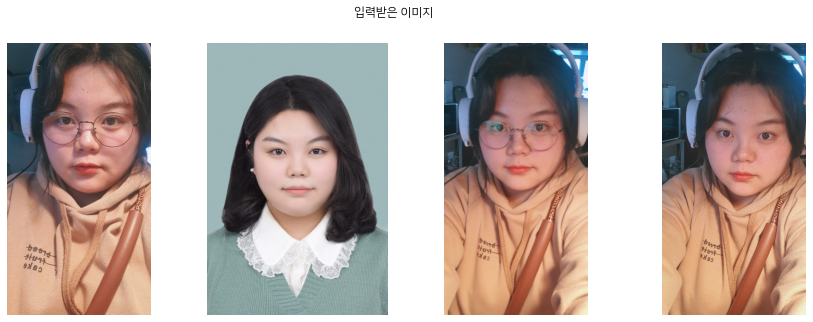

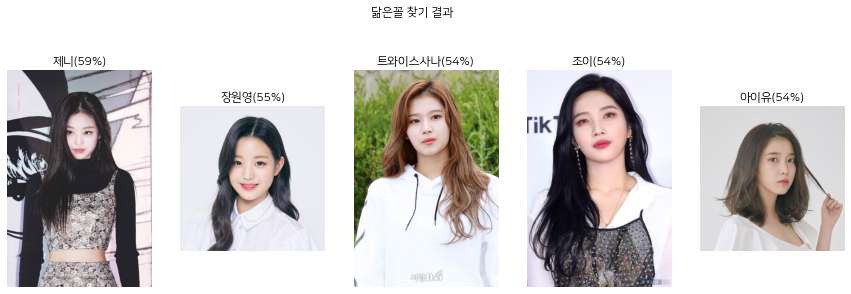

time: 1.94 s (started: 2021-02-04 22:28:06 +09:00)


In [115]:
img_dir_path = os.getenv('HOME') + '/workspace/aiffel-exploration-workspace/E07_face_embedding/images/project'
my_img_path = img_dir_path + '/my'

similarFaceFinder.find(my_img_path, verbose=1)

### 결과분석
1. 내 사진간의 임베딩 벡터 거리
    - 0, 2, 3번째 사진은 같은 날 촬영되었고 1번째 사진은 다른 날 촬영되었다.
    - 실습전 예상으로 1번째 사진과 나머지 사진들간의 간격이 클것이라 예상했었다.
    - 거리를 계산하여 확인한 결과, 실제로도 1번째 사진이 비교군이 되면 대체로 거리가 멀게 나오는 것을 확인할 수 있었다.
2. 내 사진과 가장 닮은 연예인 사진은?
    1. 각 사진 별로 가장 닮은(=벡터 간의 거리가 가장 가까운) 10명의 연예인을 각각 탐색하였다.
    2. 구해진 각 데이터 프레임을 합쳐 score(=벡터 간의 거리)가 가까운 순으로 정렬하였다. 이때, 합치는 과정에서 중복되는 name이 있다면 score의 값은 평균을 내어 값을 정하였다.
    3. 계산 결과 제니 > 장원영 > 사나 > 조이 > 아이유 순으로 닮을 꼴이 나왔다. 정말 놀라운 결과에 경악을 금할 길이 없다.

### 추가실험

#### 벡터 거리가 가까운 사진들로만 타겟 이미지셋 구성
- 결과분석에서 내 사진들 중 가장 이질적이었던 1번째 사진을 제외하고 동일한 과정을 수행해보자.

>>> face embedding start...
>>> face embedding end ✧⁺⸜(･ ᗜ ･ )⸝⁺✧

>>> distance between inserted image is ...
dist(0-1) : 0.34806902790722505
dist(0-2) : 0.3136668479747916
dist(1-2) : 0.3886669331521405


>>> scores of search result is ...


,name,score
1,제니,0.442556
2,장원영,0.465681
3,아이유,0.471160
4,리아,0.473651
5,강미나,0.475489


/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:124: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:138: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


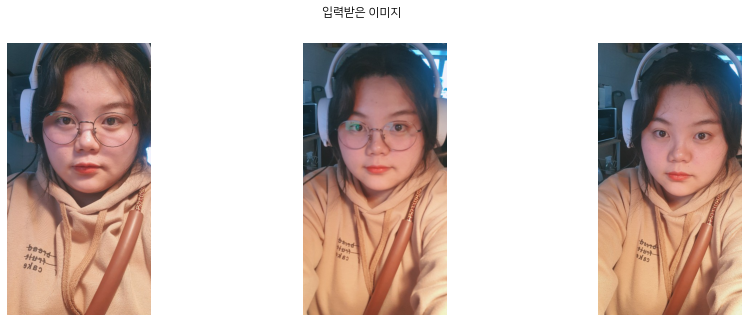

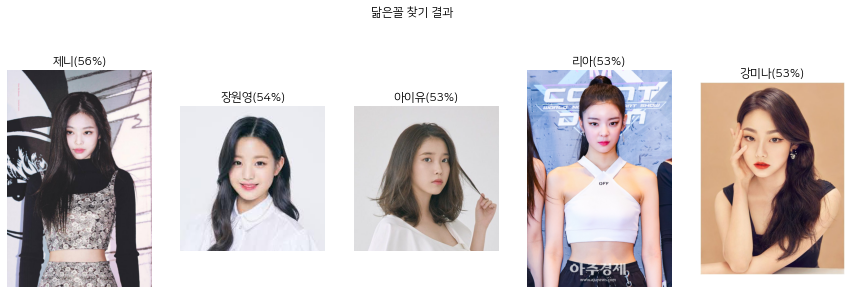

time: 1.35 s (started: 2021-02-04 22:32:12 +09:00)


In [118]:
similarFaceFinder.find(my_img_path, verbose=0)

- 확인결과, 사진상의 거리가 0.3대로 모두 비슷한것을 확인할 수 있었다.
- 이를 바탕으로 실험을 하였을 때, 얻게 된 닮은 꼴은 제니 > 장원영 > 아이유 > 리아 > 강미나 순으로, 사나/조이가 명단에서 제외되고 리아/강민아가 추가되었다.

## STEP5. 다양한 시각화 시도
---

- 작성한 클래스와 flask를 이용한여 간단한 웹앱을 만들어 보았다.
![img](./note_img/flask_1.png)
![img](./note_img/flask_2.png)
![img](./note_img/flask_05.png)

## 결론
---

### 요약
- 목표 : 임베딩 벡터의 연산을 통하여 이미지 간의 거리(=얼마나 닮았는가)를 구하고, 이를 통하여 이미지풀에서 특정 이미지와 닮은 이미지들을 닮은 순서대로 정렬할 수 있다.

### 프로젝트 평가

1. 얼굴임베딩 벡터를 활용해 가장 닮은 연예인 Best 5를 구할 수 있다. 닮은꼴 순위, 이름, 임베딩 거리를 포함한 Top-5 리스트가 정렬되어 출력되었다.
    - 입력된 이미지들을 통하여 그들과 가장 닮은 연예인 사진을 골라낼 수 있었다.
    - 위의 결과를 임베딩 거리와 연예인 이름을 포함하는 데이터프레임을 출력하였고, 이는 거리가 가까운 순으로 정렬되어있다.
2. 충분한 수의 이미지에 대한 시도를 통해 매우 닮은꼴의 연예인을 찾아냈다. 다양한 탐색을 통해 본인과 임베딩 거리 0.5 이내로 닮은 연예인을 찾아냈다.
    - 임베딩 거리가 0.4인 닮은꼴 이미지를 찾을 수 있었다.
3. 다양하고 재미있는 결과 시각화를 시도하였다. matplotlib 등 다양한 시각화 도구를 하나 이상 이용해 재미있는 결과 시각화를 구현하였다.
    - matplotilib를 이용하여 이미지를 출력하였다.

## ref
- [Python에서 Dictionary 데이터를 파일로 저장하기 (pickle)](https://ivorycirrus.github.io/TIL/python-pickle/)
- [Pandas DataFrame merge summing column](https://stackoverflow.com/questions/23361218/pandas-dataframe-merge-summing-column)
- [파이썬과 flask를 이용한 웹페이지 만들기 3편(python, vscode, flask)](https://blog.naver.com/poiulkj321/221367665053)
- [Handling File Uploads With Flask](https://blog.miguelgrinberg.com/post/handling-file-uploads-with-flask)
- [여러가지 싱글톤(singleton) 구현방법](https://wikidocs.net/3693)